In [1]:

get_ipython().run_line_magic('config', 'Completer.use_jedi = False')

# %autoreload makes Jupyter to reload modules before executing the cell
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

import copy
import os
working_dir= os.getcwd()

In [2]:

os.chdir("../src")
from MicrobiotaGAN.generator import Generator
from MicrobiotaGAN.discriminator import Discriminator
from MicrobiotaGAN.cost import wasserstein_generator_cost
from MicrobiotaGAN.cost import wasserstein_discriminator_cost
from MicrobiotaGAN.input_noise_sample import input_noise_sample
from MicrobiotaGAN.dataset_manager import DataSetManager 
from MicrobiotaGAN.glv_loss import GLV_Model
from MicrobiotaGAN.utilities import *
from MicrobiotaGAN.computational_graphs import *

os.chdir(working_dir)

In [3]:

import tensorflow as tf 

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns 
sns.set()

In [5]:
from snippets import *

In [6]:
mnist = pd.read_csv('../data/mnist_train.csv').values
mnist_set = mnist[:,1:]
print(mnist_set.shape)


(60000, 784)


In [7]:
# mnist_temp = pseudo_log_transformation(mnist_set)

mnist_temp = np.multiply(mnist_set, 1.0/255)

mnist_train = DataSetManager(mnist_temp, norm=False)

microbiota_train_set = mnist_train

In [8]:
 
n_species : int = 28*28
mini_batch_size : int =32

noise_dim : int = 10
noise_sample = tf.placeholder(tf.float32, shape=[None, noise_dim])


In [9]:
noise_dim: int = 10
noise_sample = tf.placeholder(tf.float32, shape=[None, noise_dim])



# Computation Graph Definition
my_generator = Generator(noise_dim, n_species)
my_discriminator = Discriminator(n_species)

train_real_sample, train_noise_sample, G_cost_train, G_train_step, D_cost_train, D_train_step, clip_D, D_logit_real_train, D_logit_fake_train, train_graph_saver = train_graph(
    my_discriminator, my_generator, n_species, noise_dim)

inference_real_sample, inference_noise_sample, G_cost_inference, D_cost_inference, clip_D, test_graph_saver = inference_graph(
    my_discriminator, my_generator, n_species, noise_dim)



In [10]:
graph_train_operations = [train_real_sample, train_noise_sample ,D_cost_train, clip_D, D_train_step, G_train_step, G_cost_train, train_graph_saver]

In [11]:
# Training Loop

d_train_cost = []
g_train_cost = []

epoch_record = []

glv_std_error_record = []
glv_cost_record = []

total_epochs = 1000

for k in range(total_epochs//5):

    dis_cost, gen_cost = train_gan(microbiota_train_set, graph_train_operations, mini_batch_size, 5 , my_discriminator, my_generator)

    for e in range(len(dis_cost)):   
        d_train_cost.append(dis_cost[e])

    for e in range(len(gen_cost)):    
        g_train_cost.append(gen_cost[e])

    epoch_record.append( microbiota_train_set.epochs_completed)


    print("Training epoch completed <"+str(k)+">"+" out of <"+str(total_epochs//5)+">")
    print("Generator Loss: "+str(gen_cost[-1]))
    print("Discriminator Loss: "+str(dis_cost[-1]))


Starting Traning Loop 

29.0549983410001 s
Training epoch completed <0> out of <200>
Generator Loss: 0.25012106
Discriminator Loss: 0.4958764
Starting Traning Loop 

27.825099394000063 s
Training epoch completed <1> out of <200>
Generator Loss: 0.20777741
Discriminator Loss: 0.4920158
Starting Traning Loop 

27.76049174900004 s
Training epoch completed <2> out of <200>
Generator Loss: 0.20120241
Discriminator Loss: 0.49117595
Starting Traning Loop 

27.831541852999862 s
Training epoch completed <3> out of <200>
Generator Loss: 0.21035108
Discriminator Loss: 0.48798913
Starting Traning Loop 

27.908522601000186 s
Training epoch completed <4> out of <200>
Generator Loss: 0.20813255
Discriminator Loss: 0.4832948
Starting Traning Loop 

27.891765697999972 s
Training epoch completed <5> out of <200>
Generator Loss: 0.22802734
Discriminator Loss: 0.49293238
Starting Traning Loop 

27.89933493600006 s
Training epoch completed <6> out of <200>
Generator Loss: 0.25495738
Discriminator Loss: 0.4

In [12]:
one_im = draw_gan_samples(my_generator, number_of_samples_to_draw=1)
print(one_im.shape)
print(one_im[0,0:5])

(1, 784)
[0.34696802 0.24616268 0.6731772  0.26275563 0.3995063 ]


After inverse
[0.34696802 0.24616268 0.6731772  0.26275563 0.3995063 ]


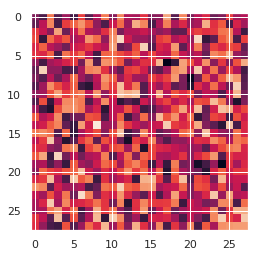

In [13]:
# one_im = inverse_pseudo_log_transformation(one_im)
# print("After inverse")
print(one_im[0,0:5])

la = one_im.reshape(28,28)
#print(la[0:4,0:4])
plt.imshow(one_im.reshape(28,28))
plt.savefig("Entranada.png")



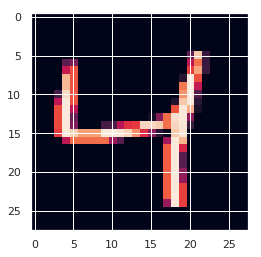

In [14]:
original = mnist[2,1:].reshape(28,28)


normalizado = np.multiply(original, 1.0/255)
plt.imshow(normalizado)
plt.savefig("Original.png")


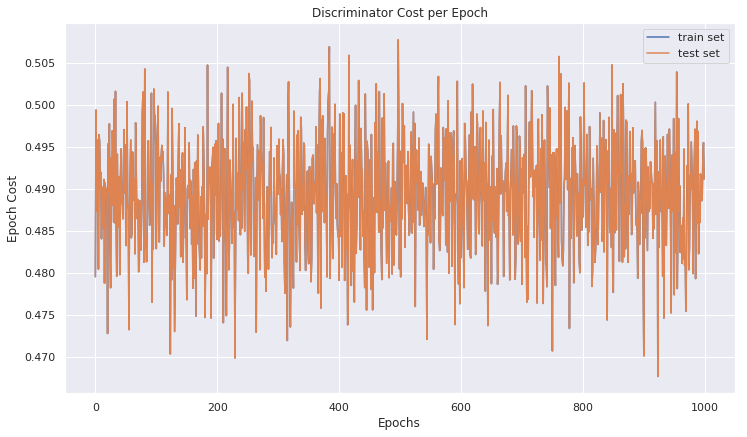

In [15]:
plot_cost(d_train_cost,d_train_cost, "Discriminator")

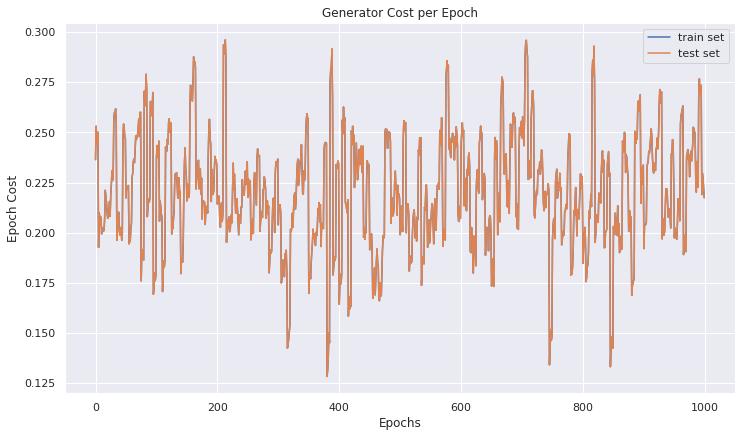

In [16]:
plot_cost(g_train_cost,g_train_cost, "Generator")

In [ ]:
# NOTE: use the saver from the training graph

test_train_operations = [inference_real_sample, inference_noise_sample, D_cost_inference, clip_D,  G_cost_inference, train_graph_saver]

In [ ]:
d_test_cost, g_test_cost = test_gan( microbiota_test_set, test_train_operations, mini_batch_size, total_epochs)

In [ ]:
plot_cost(d_train_cost,d_test_cost, "Discriminator")

In [ ]:
plot_cost(g_train_cost,g_test_cost, "Generator")

In [ ]:
# Quick Test
n_samples = 10000
gan_samples = draw_gan_samples(my_generator, number_of_samples_to_draw=n_samples)
gan_samples =  inverse_pseudo_log_transformation(gan_samples)

In [ ]:
def vector_glv_error(samples,m_A, m_r):
    error_record = []
    for k in range(len(samples)):
        e = GLV_Model(samples[k,:],m_A, m_r)
        error_record.append(e)
    return np.array(error_record)
    

In [ ]:
transformed_abundance = copy.copy(microbiota_table)

rnd_index = np.random.randint(low=1, high=microbiota_table.shape[0],size=n_samples)

sub_ds = inverse_pseudo_log_transformation(transformed_abundance[rnd_index])

gan_samples_error      = vector_glv_error(gan_samples,m_A, m_r)
original_samples_error = vector_glv_error(sub_ds,m_A, m_r)

In [ ]:
current_epochs = microbiota_train_set.epochs_completed 
plot_glv_error_boxplot(gan_samples_error, original_samples_error, current_epochs , n_samples)

In [ ]:
plot_glv_epoch_standard_error(epoch_record, glv_std_error_record)

In [ ]:
plot_glv_cost(epoch_record,glv_cost_record)

In [ ]:
np.min(current_draw)